In [1]:
from pathlib import Path
import time

import torch
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

from vesuvius.data.vesuvius_train import VesuviusTrainDataset
from vesuvius.data.subset_with_transform import SubsetWithTransform

from vesuvius.transforms.get_transforms import get_transformations

from vesuvius.models.unet3d_small import SmallUNet3D
from vesuvius.losses import DiceBCELoss
from vesuvius.losses.targets import make_binary_targets
from vesuvius.metrics import dice_from_logits

ROOT = Path("~/vesuvius-scroll-detection/data/raw/vesuvius").expanduser()
print("ROOT:", ROOT)

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("Device:", device)

ROOT: /Users/chamu/vesuvius-scroll-detection/data/raw/vesuvius
Device: mps


In [2]:
ds = VesuviusTrainDataset(ROOT)
print("Dataset size:", len(ds))

val_fraction = 0.15
seed = 0

n_total = len(ds)
n_val = max(1, int(val_fraction * n_total))
n_train = n_total - n_val

g = torch.Generator().manual_seed(seed)
train_subset, val_subset = random_split(ds, [n_train, n_val], generator=g)

print("Train subset:", len(train_subset))
print("Val subset:", len(val_subset))

Dataset size: 806
Train subset: 686
Val subset: 120


In [3]:
PATCH = (16, 64, 64)  # start small for speed; later try (32, 96, 96)
print("PATCH:", PATCH)

val_tf, train_tf = get_transformations(
    crop_size=PATCH,
    use_random_crop_for_train=True,
    mean=None,
    std=None,
    use_flips=True,
    use_intensity_jitter=True,
    use_gaussian_noise=True,
)

train_ds = SubsetWithTransform(train_subset, transform=train_tf)
val_ds   = SubsetWithTransform(val_subset, transform=val_tf)

PATCH: (16, 64, 64)


In [4]:
batch_size = 1

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

imgs, masks, sids = next(iter(train_loader))
print("imgs:", imgs.shape, imgs.dtype)
print("masks:", masks.shape, masks.dtype, "unique:", torch.unique(masks))
print("sid:", sids[0])

imgs: torch.Size([1, 1, 16, 64, 64]) torch.float32
masks: torch.Size([1, 1, 16, 64, 64]) torch.float32 unique: tensor([0., 1., 2.])
sid: 1796762532


In [5]:
model = SmallUNet3D(in_channels=1, base_channels=16).to(device)

loss_fn = DiceBCELoss(w_bce=0.5, w_dice=0.5)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

In [6]:
epochs = 3
threshold = 0.5

train_loss_hist = []
val_loss_hist = []
dice_hist = []

for ep in range(1, epochs + 1):
    # -------------------
    # TRAIN
    # -------------------
    model.train()
    tr_loss_sum = 0.0
    tr_n = 0

    t0 = time.time()
    for i, (imgs, masks, _sids) in enumerate(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        targets, valid = make_binary_targets(masks, ignore_label=2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = loss_fn(logits, targets, valid)

        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        tr_loss_sum += (loss.detach().cpu().item() * bs)  # sync only once per batch
        tr_n += bs

        # progress print so it never looks "stuck"
        if i % 50 == 0:
            print(f"  [train] ep {ep:03d} batch {i:04d}/{len(train_loader)} loss={loss.detach().cpu().item():.4f}", flush=True)

    tr_loss = tr_loss_sum / max(1, tr_n)
    train_loss_hist.append(tr_loss)

    # -------------------
    # VAL
    # -------------------
    model.eval()
    va_loss_sum = 0.0
    va_n = 0
    dice_sum = 0.0

    with torch.no_grad():
        for i, (imgs, masks, _sids) in enumerate(val_loader):
            imgs = imgs.to(device)
            masks = masks.to(device)

            targets, valid = make_binary_targets(masks, ignore_label=2)

            logits = model(imgs)
            loss = loss_fn(logits, targets, valid)

            bs = imgs.size(0)
            va_loss_sum += (loss.detach().cpu().item() * bs)
            va_n += bs

            d = dice_from_logits(logits, targets, valid, threshold=threshold)["dice"]
            dice_sum += float(d) * bs

            if i % 100 == 0:
                print(f"  [val  ] ep {ep:03d} batch {i:04d}/{len(val_loader)}", flush=True)

    va_loss = va_loss_sum / max(1, va_n)
    dice = dice_sum / max(1, va_n)

    val_loss_hist.append(va_loss)
    dice_hist.append(dice)

    dt = time.time() - t0
    print(f"epoch {ep:03d} | train_loss={tr_loss:.6f} | val_loss={va_loss:.6f} | dice={dice:.4f} | time={dt:.1f}s")

  [train] ep 001 batch 0000/686 loss=0.0000
  [train] ep 001 batch 0050/686 loss=0.7290
  [train] ep 001 batch 0100/686 loss=0.0000
  [train] ep 001 batch 0150/686 loss=0.6792
  [train] ep 001 batch 0200/686 loss=0.6514
  [train] ep 001 batch 0250/686 loss=0.6430
  [train] ep 001 batch 0300/686 loss=0.6511
  [train] ep 001 batch 0350/686 loss=0.6363
  [train] ep 001 batch 0400/686 loss=0.5526
  [train] ep 001 batch 0450/686 loss=0.0000
  [train] ep 001 batch 0500/686 loss=0.0000
  [train] ep 001 batch 0550/686 loss=0.6003
  [train] ep 001 batch 0600/686 loss=0.5851
  [train] ep 001 batch 0650/686 loss=0.0000
  [val  ] ep 001 batch 0000/120
  [val  ] ep 001 batch 0100/120
epoch 001 | train_loss=0.462612 | val_loss=0.537597 | dice=0.2698 | time=200.6s
  [train] ep 002 batch 0000/686 loss=0.5663
  [train] ep 002 batch 0050/686 loss=0.5895
  [train] ep 002 batch 0100/686 loss=0.6564
  [train] ep 002 batch 0150/686 loss=0.5603
  [train] ep 002 batch 0200/686 loss=0.5420
  [train] ep 002 bat

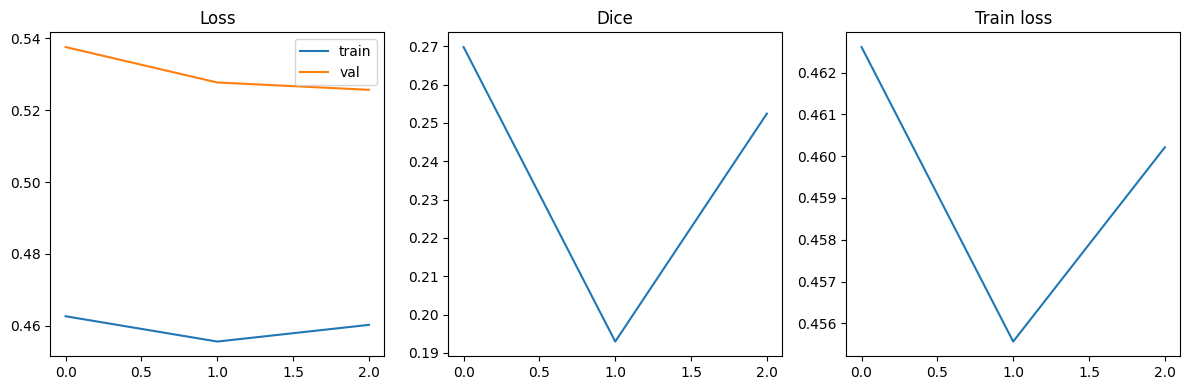

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(dice_hist)
plt.title("Dice")

plt.subplot(1,3,3)
plt.plot(train_loss_hist)
plt.title("Train loss")

plt.tight_layout()
plt.show()

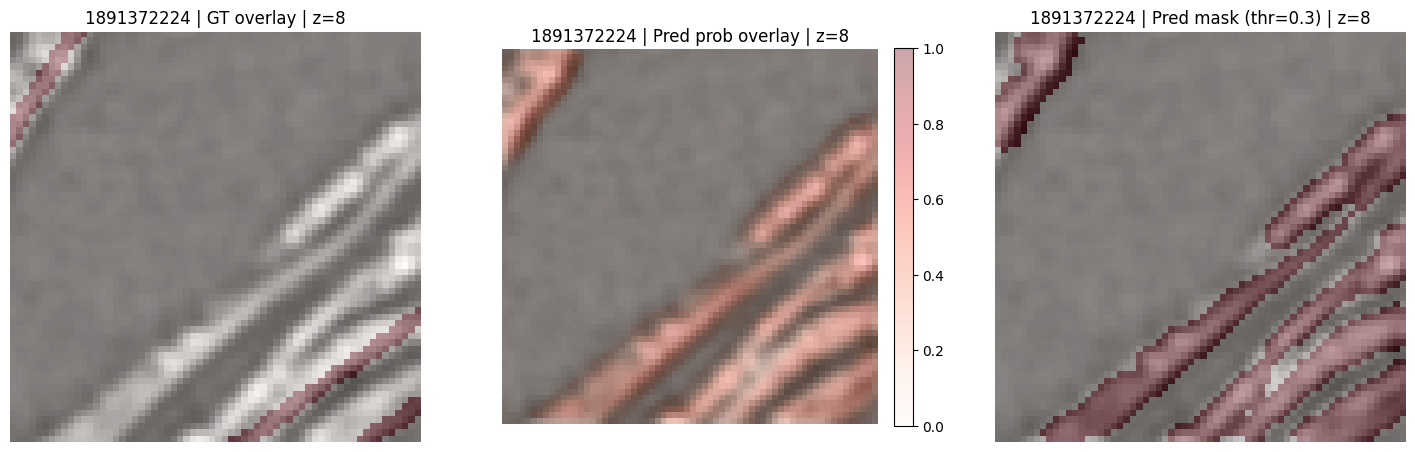

prob min/max: 0.012334787286818027 0.5952269434928894


In [8]:
model.eval()
imgs, masks, sids = next(iter(val_loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = model(imgs)
    probs = torch.sigmoid(logits)

img = imgs.detach().cpu()[0]    # (1,D,H,W)
mask = masks.detach().cpu()[0]  # (1,D,H,W)
prob = probs.detach().cpu()[0]  # (1,D,H,W)

sid = sids[0]
z = img.shape[1] // 2
thr = 0.3

plt.figure(figsize=(18,6))

# 1) GT overlay
plt.subplot(1,3,1)
plt.imshow(img[0, z], cmap="gray")
plt.imshow((mask[0, z] == 1), alpha=0.35, cmap="Reds")
plt.title(f"{sid} | GT overlay | z={z}")
plt.axis("off")

# 2) Pred prob overlay + colorbar
plt.subplot(1,3,2)
plt.imshow(img[0, z], cmap="gray")
im = plt.imshow(prob[0, z], alpha=0.35, cmap="Reds", vmin=0.0, vmax=1.0)
plt.title(f"{sid} | Pred prob overlay | z={z}")
plt.axis("off")
plt.colorbar(im, fraction=0.046, pad=0.04)

# 3) Pred mask overlay
plt.subplot(1,3,3)
plt.imshow(img[0, z], cmap="gray")
plt.imshow((prob[0, z] > thr), alpha=0.35, cmap="Reds")
plt.title(f"{sid} | Pred mask (thr={thr}) | z={z}")
plt.axis("off")

plt.show()

print("prob min/max:", float(prob.min()), float(prob.max()))